In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.io as spio
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import os
import regex as re

%load_ext autoreload
%autoreload 2

In [2]:
MIN_CONF = 0.7

# 1. Pre-process data

In [3]:
data_path = Path(os.getcwd()) / 'tesla'

In [4]:
output_path = data_path / 'output'
output_path.mkdir(parents=True, exist_ok=True)

imgs_fpaths = sorted((data_path / 'front_frames_79').glob('*.png'))
images = [np.array(Image.open(fpath)) for fpath in imgs_fpaths]

numpy_fpaths = sorted((data_path / 'depth_npy_79').glob('frame*.npy'))

flenghs_fpaths = [fpath for fpath in numpy_fpaths if re.search(r'_flpx', str(fpath))]
depths_fpaths = [fpath for fpath in numpy_fpaths if not re.search(r'_flpx', str(fpath))]


In [5]:
depths_fpaths[0]

PosixPath('/home/davigv/ist/piv/piv-hw/Part2/tesla/depth_npy_79/frame_000001.npy')

In [7]:

depth_maps = [np.load(fpath) for fpath in depths_fpaths]
flenghs = [np.load(fpath) for fpath in flenghs_fpaths]


In [8]:
conf_maps = [np.where(depth_map < 100, 1.0, 0.0) for depth_map in depth_maps]

In [9]:
# # Loading cams info

# cams_info_raw = spio.loadmat(cams_info_fpath)['cams_info']
# cams_info = []
# for datapoint in cams_info_raw:
#     img = datapoint[0][0][0][0]
#     depth_map = datapoint[0][0][0][1]
#     conf_map = datapoint[0][0][0][2]
#     focal_length = datapoint[0][0][0][3][0][0]
#     cams_info.append({'focal_length':focal_length, 'rgb':img, 'depth':depth_map, 'conf': conf_map})

In [10]:
# Calculate sift keypoints and descriptions

sift = cv2.SIFT_create()

# Extract keypoints and descriptors for each image
keypoints = []
descriptors = []

for img in tqdm(images):
    kps, descs = sift.detectAndCompute(img, None)
    keypoints_array = np.array([kp.pt for kp in kps], dtype=np.float32)
    descs = descs.astype(np.float32)
    keypoints.append(keypoints_array)
    descriptors.append(descs)

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


In [11]:
from utils.ImageNode import ImageNode
image_nodes:ImageNode = []

for i in range(len(images)):
    image_nodes.append(ImageNode(
        idx=i,
        rgb=images[i],
        keypoints=keypoints[i],
        descriptors=descriptors[i],
        depth_map=depth_maps[i],
        conf_map=conf_maps[i],
        focal_length=flenghs[i].item()
    ))

In [12]:
# plt.imshow(image_nodes[0].get_high_conf_img())

In [13]:
# from utils.plot import draw_image_keypoints, draw_matches_points, plot_point_cloud_with_keypoints

# node = image_nodes[0]
# plt.imshow(draw_image_keypoints(node.rgb, node.keypoints))

In [14]:
node1 = image_nodes[1]
node2 = image_nodes[2]


# 2. Visualize point cloud

In [15]:
from utils.plot import plot_point_cloud_with_keypoints

plot_point_cloud_with_keypoints(node1.point_cloud, node1.keypoints_3d)

# 3. Compute 2d and 3d match between images

In [16]:
from utils.ImageNodeMatch import ImageNodesMatch

nodes_match = {}
for i in range(1, len(image_nodes)):
    node1 = image_nodes[i - 1]
    node2 = image_nodes[i]
    matching_nodes = ImageNodesMatch(node2, node1)
    nodes_match.update({matching_nodes.pair_idx: matching_nodes})

# 4. Visualize 2d matches

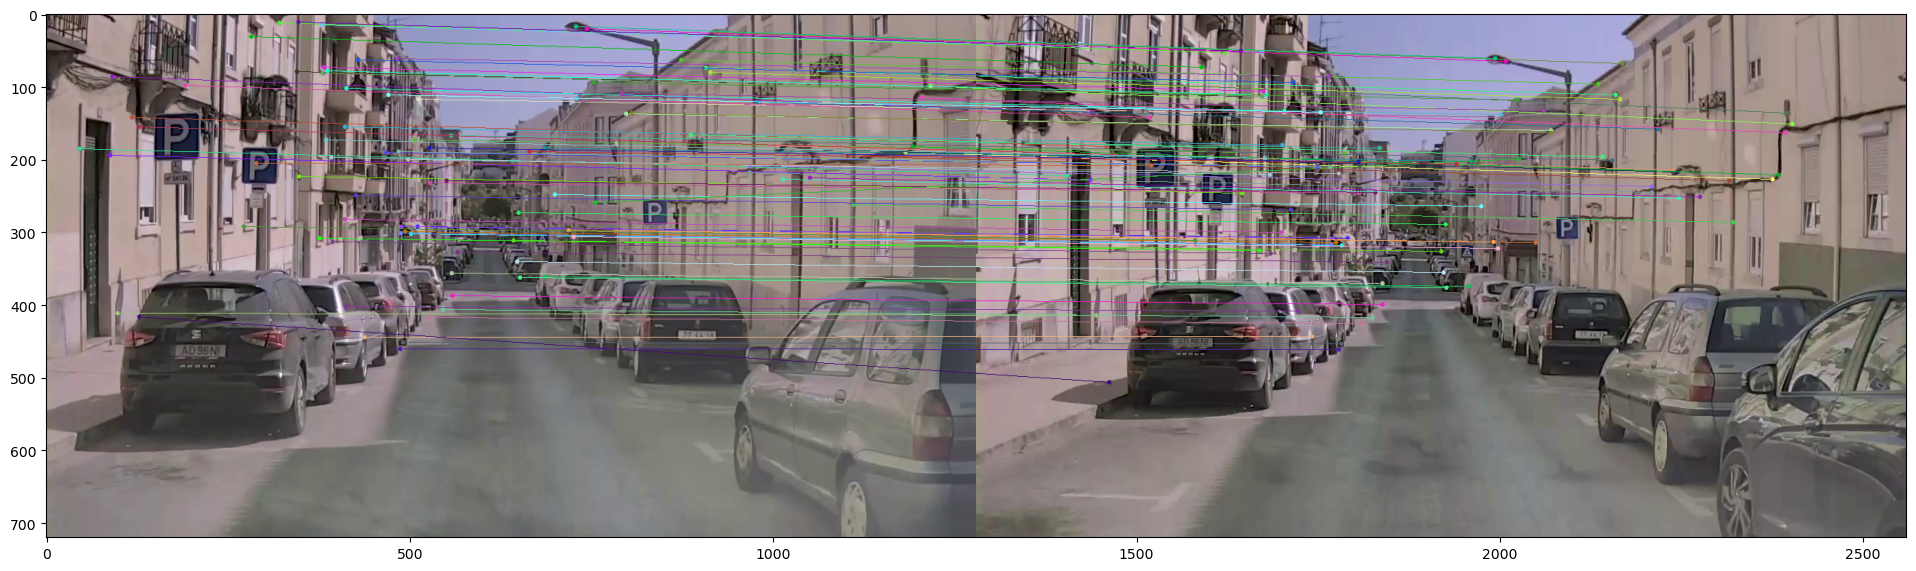

In [17]:
from utils.plot import draw_matches_points


match = nodes_match[(1,0)]
src_pts, dst_pts = match.get_2d_match_pts()

canvas = draw_matches_points(img1=match.src_node.rgb, img2=match.dst_node.rgb, src_points=match.src_2d, dst_points=match.dst_2d, max_points=100)
plt.figure(figsize=(24, 16))  # Adjust the figure size as needed
plt.imshow(canvas)
plt.show()

# 4. Testing transformation

In [20]:
from utils.plot import register_point_cloud, write_point_cloud

m = nodes_match[(1,0)]
# dst_transformed = m.apply_transform(m.dst_node.point_cloud, m.transform_procrustes)
pcd = register_point_cloud(m.dst_node.point_cloud, m.dst_node.cloud_colors/255)
write_point_cloud(pcd, 'dst_pcloud.ply')


In [21]:
from utils.plot import register_point_cloud, write_point_cloud

# Some direct transforms
direct_matches = [(1,0)]
for match_id in direct_matches:
    m = nodes_match[match_id]
    src_transformed = m.apply_transform(m.src_node.point_cloud, m.transform_icp)
    pcd = register_point_cloud(src_transformed, m.src_node.cloud_colors/255)
    write_point_cloud(pcd, f'src_{match_id}.ply')